我们用机器模拟的时点负荷数据做一个缺失值统计，通过绘图呈现负荷数据缺失的概貌

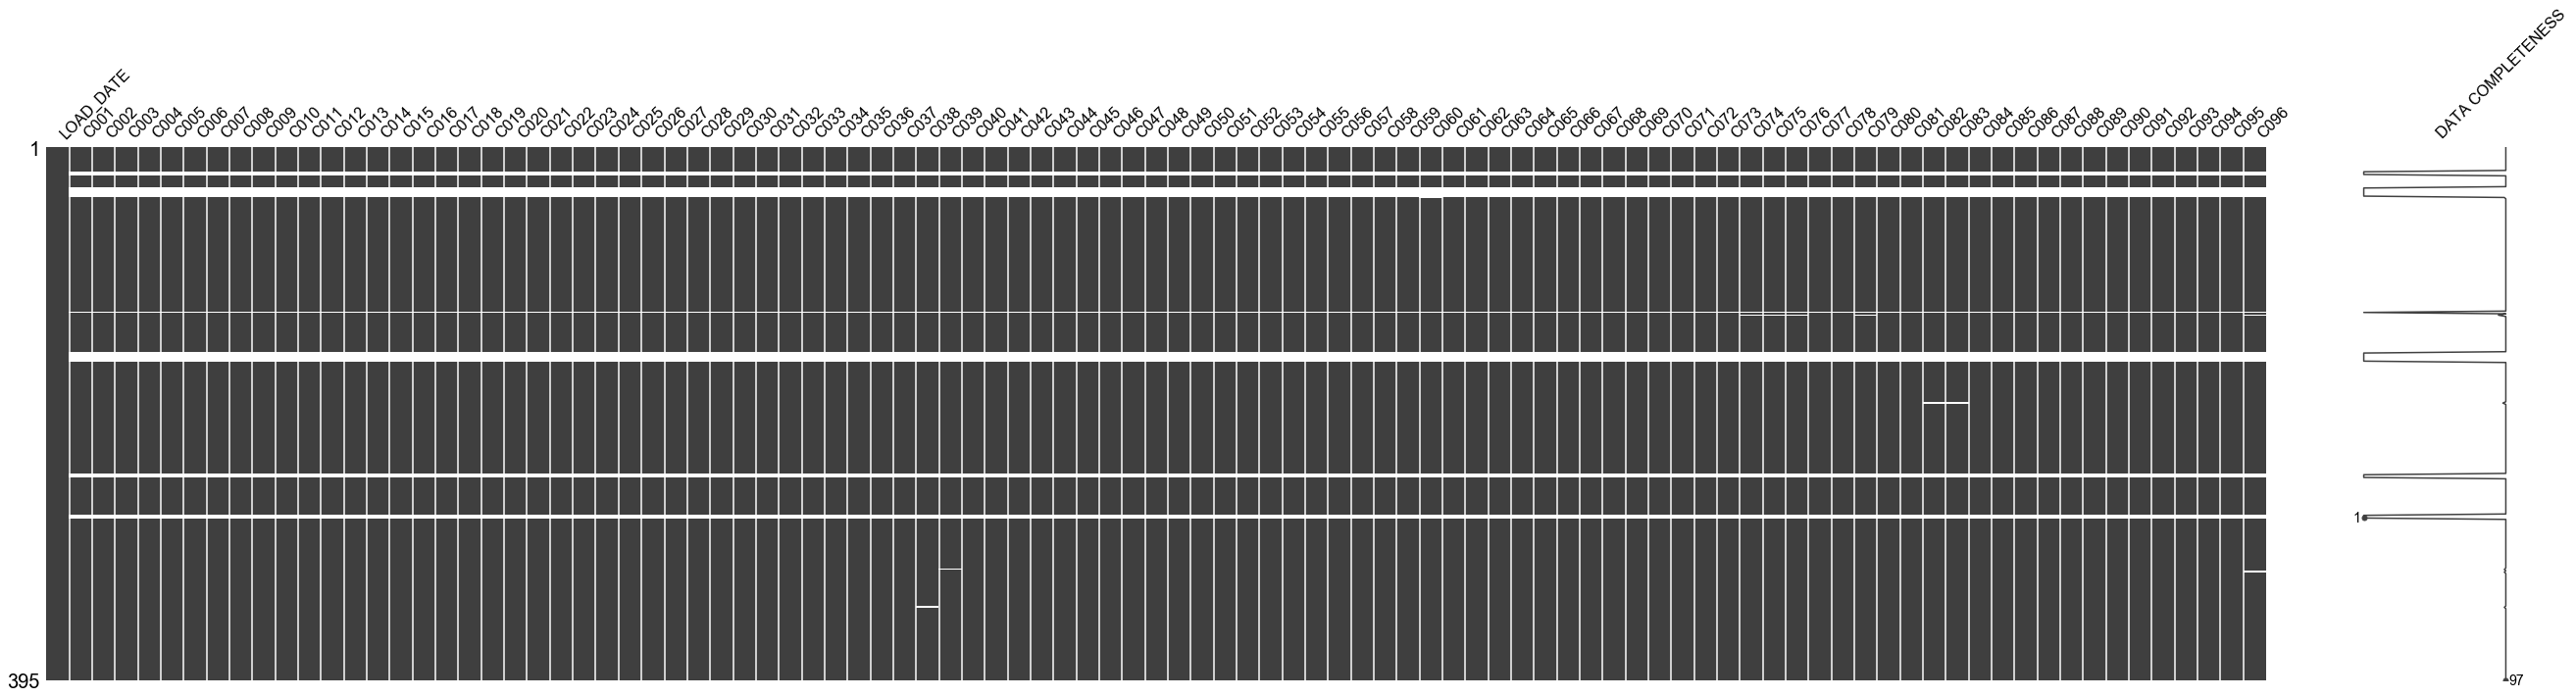

In [1]:
import missingno as msno
import pandas as pd
import matplotlib
# 以下 font.family 设置仅适用于 Mac系统，其它系统请使用对应字体名称
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
data = pd.read_csv("http://image.cador.cn/data/energy_out.csv")
msno.matrix(data, labels=True,figsize=(45,10))

现编写Python代码基于K近邻的思路对缺失值进行插补

In [2]:
import datetime
import numpy as np
weth = pd.read_csv("http://image.cador.cn/data/weather.csv")
# 获取星期数据
data['weekday']=[datetime.datetime.strptime(x,'%Y/%m/%d').weekday() for x in data.LOAD_DATE]
# 获取月份数据
data['month']=[datetime.datetime.strptime(x,'%Y/%m/%d').month for x in data.LOAD_DATE]
data['date']=[datetime.datetime.strptime(x,'%Y/%m/%d') for x in data.LOAD_DATE]
# 将数据按日期升序排列
data = data.sort_values(by='date')
# 获取时间趋势数据
data['trend'] = range(data.shape[0])
# 设置索引并按索引进行关联
data=data.set_index('LOAD_DATE')
weth=weth.set_index('WETH_DATE')
p = data.join(weth)
p = p.drop(columns='date')
# 声明列表用于存储位置及插补值信息
out = list()
for index in np.where(p.apply(lambda x:np.sum(np.isnan(x)),axis=1)>0)[0]:
    selcol = np.logical_not(np.isnan(p.iloc[index]))
    usecol = np.where(selcol)[0]
    cols = np.where(~selcol)[0]
    for col in cols:
        nbs = np.where(p.iloc[:,usecol].apply(lambda x:np.sum(np.isnan(x)),axis=1)==0)[0]
        nbs = nbs[nbs != index]
        nbs = (list(set(nbs).intersection(set(np.where(np.logical_not(np.isnan(p.iloc[:,col])))[0]))))
        t0 = [np.sqrt(np.sum((p.iloc[index,usecol]-p.iloc[x,usecol])**2)) for x in nbs]
        t1 = 1/np.array(t0)
        t_wts = t1/np.sum(t1)
        out.append((index,col,np.sum(p.iloc[nbs,col].values*t_wts)))

我们可将out打印出来，查看其取值的情况

In [3]:
out[0:10]

[(18, 0, 15.877932471145733),
 (18, 1, 15.107482604538141),
 (18, 2, 14.247447130649874),
 (18, 3, 13.637888316974843),
 (18, 4, 13.537397118266925),
 (18, 5, 13.805422103976255),
 (18, 6, 13.191140292458323),
 (18, 7, 12.395420895966566),
 (18, 8, 12.612580328443027),
 (18, 9, 12.325141881865681)]

基于out可对数据p进行缺失值插补

In [4]:
for v in out:
    p.iloc[v[0],v[1]]=v[2]
    
p.head()

,C001,C002,C003,C004,C005,C006,C007,C008,C009,C010,...,C093,C094,C095,C096,weekday,month,trend,MEAN_TMP,MIN_TMP,MAX_TMP
LOAD_DATE,,,,,,,,,,,,,,,,,,,,,
2013/9/1,16.18,10.28,12.84,10.18,11.24,10.90,10.86,10.38,10.26,9.76,...,22.00,18.28,17.92,21.40,6,9,0,26.5,23.4,31.2
2013/9/2,18.38,17.76,16.74,14.30,15.46,15.86,14.48,14.00,14.88,14.38,...,27.82,21.56,22.98,24.68,0,9,1,28.1,25.5,32.2
2013/9/3,24.94,19.74,21.86,17.12,21.00,32.38,20.38,16.76,16.74,16.92,...,15.94,16.24,17.66,15.82,1,9,2,25.9,24.5,28.7
2013/9/4,17.06,13.28,13.00,15.12,13.88,13.10,13.38,14.22,13.44,12.54,...,20.36,18.76,19.86,16.86,2,9,3,24.7,22.9,26.1
2013/9/5,12.30,15.22,11.18,11.08,9.68,12.72,11.28,10.52,10.16,9.94,...,19.12,22.28,16.86,11.14,3,9,4,24.5,22.8,26.2


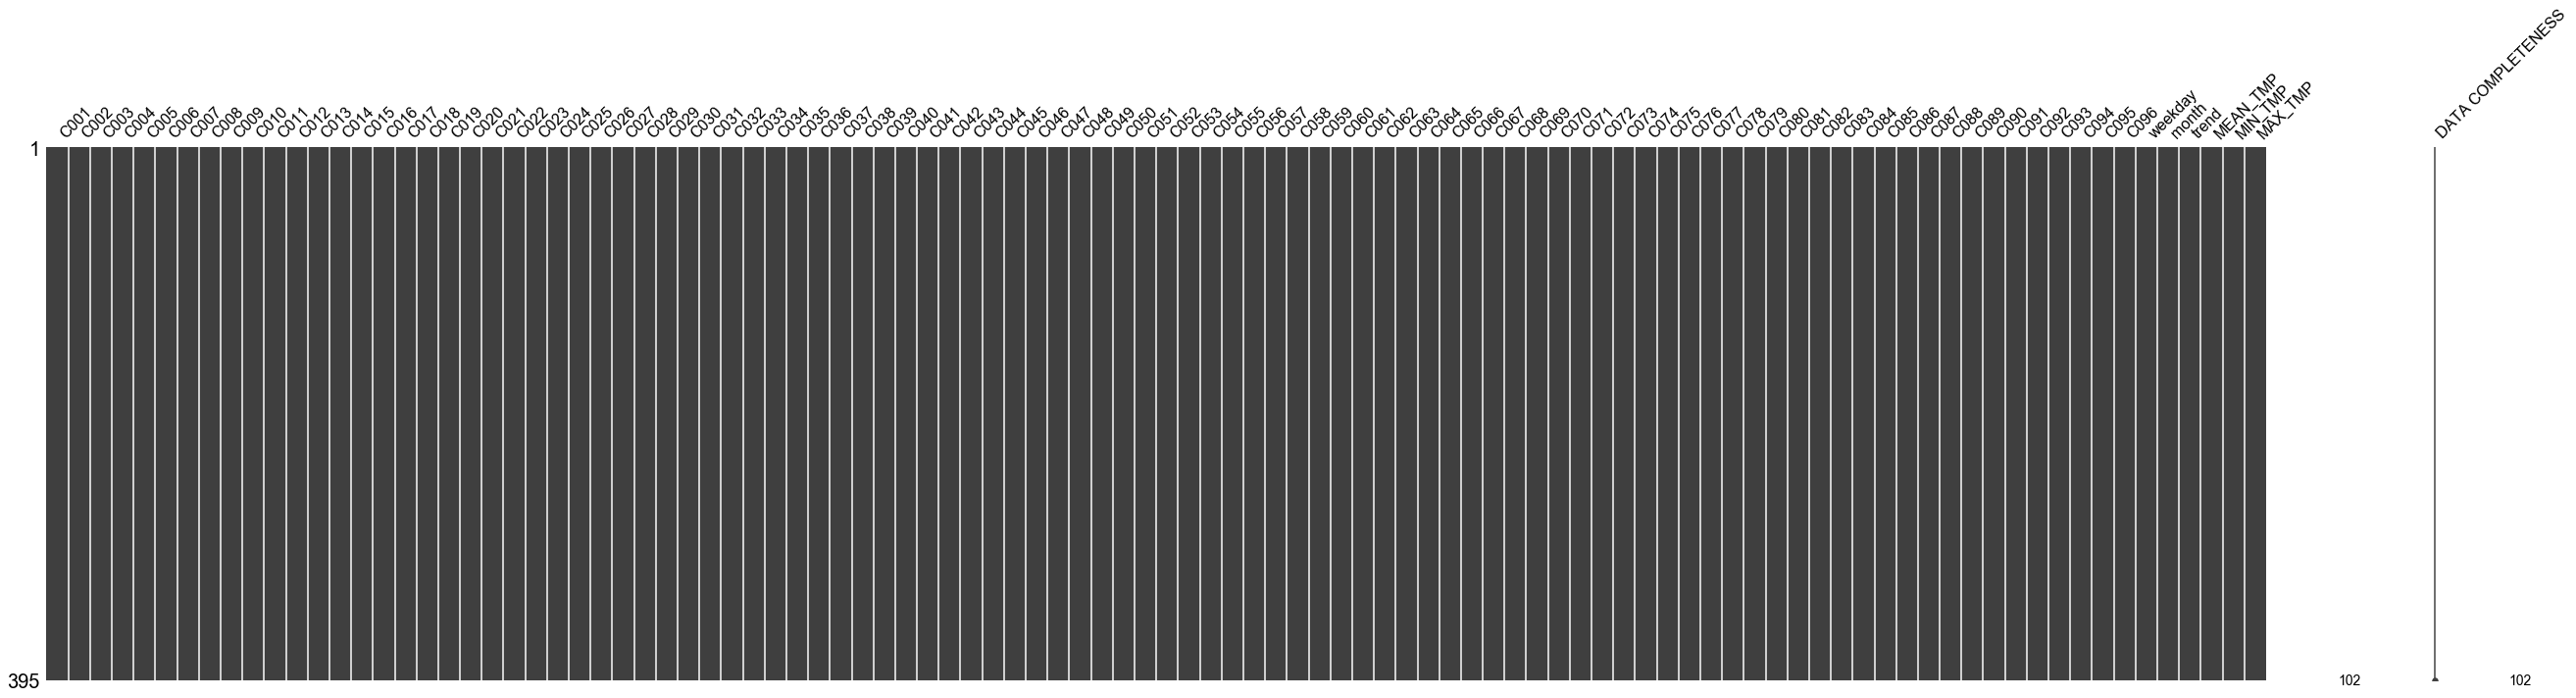

In [5]:
msno.matrix(p, labels=True,figsize=(45,10))

In [6]:
p.to_csv('data/p.csv', index=False)